In [428]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [429]:
hitters=pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/ISLR/Hitters.csv')
hitters.drop('Unnamed: 0', axis=1, inplace=True)
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


The dataset has missing values:

In [430]:
hitters.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

I will remove all rows where the Salary data is missing:

In [431]:
hitters.dropna(inplace=True)

# One hot encode the categorical columns
categorical_columns=['League', 'Division', 'NewLeague']
numerical_columns=list(hitters.drop(categorical_columns, axis=1, inplace=False).columns)
numerical_columns.remove('Salary')
hitters=pd.get_dummies(hitters, columns=categorical_columns, drop_first=True)

# Split the data into a training set and test set
train, test = train_test_split(hitters, test_size=0.4, random_state=18)
train.shape, test.shape

((157, 20), (106, 20))

In [432]:
X_train, y_train = train.drop('Salary', axis=1, inplace=False), train['Salary']
X_test, y_test = test.drop('Salary', axis=1, inplace=False), test['Salary']

# Standardize the numerical columns
mean, std = X_train[numerical_columns].mean(), X_train[numerical_columns].std()

X_train[numerical_columns]=(X_train[numerical_columns]-mean)/std
X_test[numerical_columns]=(X_test[numerical_columns]-mean)/std

I will now look at how regression coefficients change as function of the tuning parameter $\lambda$.

Text(0.5,1,'Ridge Regression Coefficients')

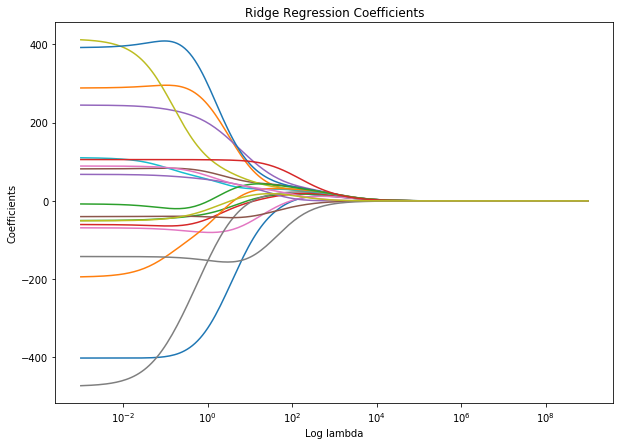

In [433]:
lambdas=10**np.linspace(-3,9,201)
ridge_coeffs=[]
for val in lambdas:
    ridge_model=Ridge(alpha=val)
    ridge_model.fit(X_train, y_train)
    ridge_coeffs.append(list(ridge_model.coef_))
ridge_coeffs=np.array(ridge_coeffs).T
plt.figure(figsize=(10,7))
for i in range(19):
    plt.plot(lambdas, ridge_coeffs[i])
plt.xlabel('Log lambda')
plt.ylabel('Coefficients')
plt.xscale('log')
plt.title('Ridge Regression Coefficients')

In [434]:
def get_test_MSE(X_train, X_test, y_train, y_test, lambdas, method='Ridge'):
    """
    Output: array, shape=(1, len(lambdas))
    """
    assert method in ['Ridge', 'Lasso']
    test_MSE=[]
    if method=='Ridge':
        for val in lambdas:
            est=Ridge(alpha=val)
            est.fit(X_train, y_train)
            test_MSE.append(mean_squared_error(y_test, est.predict(X_test)))
    else:
        for val in lambdas:
            est=Lasso(alpha=val)
            est.fit(X_train, y_train)
            test_MSE.append(mean_squared_error(y_test, est.predict(X_test)))
    return np.array(test_MSE)

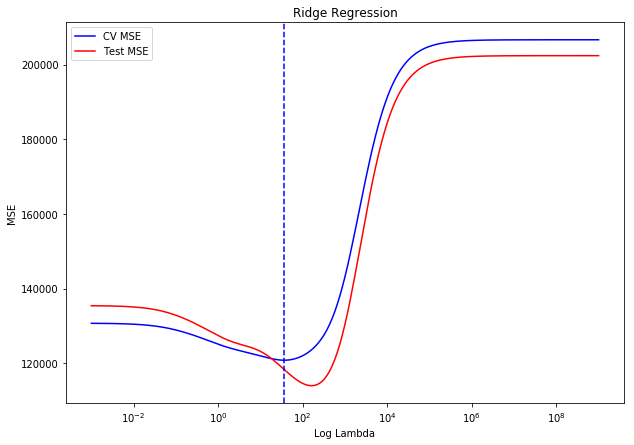

In [435]:
# Choose the best lambda by cross-validation.
# Plot the CV MSE as function of lambda.
RCV=RidgeCV(alphas=lambdas, store_cv_values=True)
RCV.fit(X_train, y_train)
ridge_val_MSE=RCV.cv_values_.mean(axis=0)
ridge_test_MSE=get_test_MSE(X_train, X_test, y_train, y_test, lambdas)
plt.figure(figsize=(10,7))
plt.plot(lambdas, ridge_val_MSE, color='blue', label='CV MSE')
plt.plot(lambdas, ridge_test_MSE, color='red', label='Test MSE')
plt.xlabel('Log Lambda')
plt.ylabel('MSE')
plt.xscale('log')
plt.legend(loc='best')
plt.title('Ridge Regression')
plt.axvline(x=RCV.alpha_, linestyle='--', color='blue')

In [436]:
print('Best lambda for Ridge Regression is: {}'.format(RCV.alpha_))

Best lambda for Ridge Regression is: 36.3078054770101


In [437]:
print('Ridge Test MSE: {}'.format(mean_squared_error(y_test, RCV.predict(X_test))))

Ridge Test MSE: 118338.6315162025


C:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


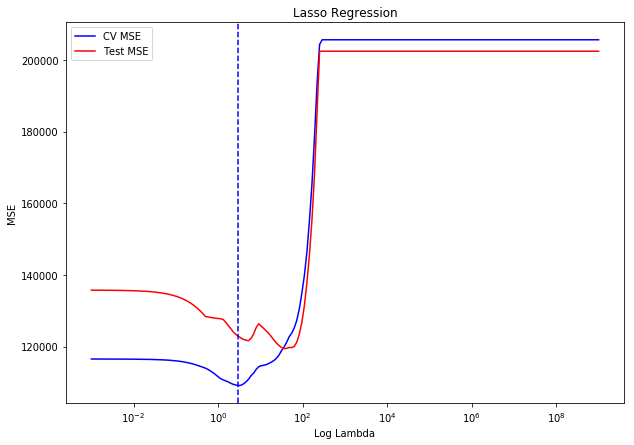

In [438]:
# Perform Lasso Regression
LCV=LassoCV(alphas=lambdas, cv=5)
LCV.fit(X_train, y_train)
lasso_val_MSE=LCV.mse_path_.mean(axis=1)[::-1]
lasso_test_MSE=get_test_MSE(X_train, X_test, y_train, y_test, lambdas, method='Lasso')
plt.figure(figsize=(10,7))
plt.plot(lambdas, lasso_val_MSE, color='blue', label='CV MSE')
plt.plot(lambdas, lasso_test_MSE, color='red', label='Test MSE')
plt.axvline(x=LCV.alpha_, linestyle='--', color='blue')
plt.xlabel('Log Lambda')
plt.xscale('log')
plt.ylabel('MSE')
plt.title('Lasso Regression')
plt.legend(loc='best')

In [439]:
print('Best lambda for Ridge Regression is: {}'.format(LCV.alpha_))

Best lambda for Ridge Regression is: 3.019951720402016


In [440]:
print('Lasso Test MSE: {}'.format(mean_squared_error(y_test, LCV.predict(X_test))))

Lasso Test MSE: 122911.57137100078


The results show that ridge and lasso regressions can outperform least squares. In the Lasso MSE plot, the CV and test MSE become constant after a value of $\lambda$. This is expected, since lasso regression performs variable selection. As $\lambda \to \infty$, coefficients of the predictors become 0, hence for a sufficiently large tuning parameter all coefficients will be null.